# Covid 19 Chest X-Ray Analysis with GradCam

In this Notebook I use a pretrained `densenet121` for analysing Covid-19 Xrays and Visualise them using GradCam algorithm.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image,ImageOps
import torchvision
from torch import optim,nn
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from util_grad import *

## Read  and  Process  Data

In [3]:
## Define transfoms
standard_normalization = transforms.Normalize((0.5), (0.5))
data_transforms = transforms.Compose([transforms.RandomResizedCrop(256),
                                     transforms.ToTensor(),
                                     standard_normalization])


In [4]:
# Read Data
dict_ = {0:"Covid",1:"Lung_Opacity",2:"Normal",3:"Viral Pheumonia"}

df = pd.read_csv("../input/processed-csv/data.csv")
df = pd.concat([df,pd.get_dummies(df.tag)], axis=1)


In [5]:
#make train, test and val set

train, test = train_test_split(df,test_size=.2)
train_, val = train_test_split(train,test_size=.2)

In [6]:
#reseting index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train_ = train_.reset_index(drop=True)
val = val.reset_index(drop=True)

In [7]:
#make dataloader
root_dir = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

trainset = Xray_dataset(train,root_dir,transform = data_transforms)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = Xray_dataset(test,root_dir,transform = data_transforms)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

trainset_ = Xray_dataset(train_,root_dir,transform = data_transforms)
train_loader_ = DataLoader(trainset_, batch_size=32, shuffle=True)

valset = Xray_dataset(val,root_dir,transform = data_transforms)
val_loader = DataLoader(valset, batch_size=32, shuffle=True)

use_cuda = torch.cuda.is_available()
num_classes = 4

loaders = {"train": train_loader_,
           "test": test_loader,
           "val": val_loader}

## Download and Prepare Neural Network

In [8]:
model = torchvision.models.densenet121(pretrained = True, progress = True) 
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
if use_cuda:
    model = model.cuda()

In [9]:
## Define Loss and optim
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Train Model

In [10]:
## Train
train_model(20, loaders, model, optimizer, criterion, use_cuda, 'model_transfer.pt');

Epoch 1, Batch 1 loss: 1.305270
Epoch 1, Batch 51 loss: 1.193585
Epoch 1, Batch 101 loss: 1.161972
Epoch 1, Batch 151 loss: 1.140138
Epoch 1, Batch 201 loss: 1.127053
Epoch 1, Batch 251 loss: 1.109644
Epoch 1, Batch 301 loss: 1.094884
Epoch 1, Batch 351 loss: 1.077175
Epoch 1, Batch 401 loss: 1.063130
Epoch: 1 	Training Loss: 1.057074 	Validation Loss: 0.915297
Validation loss decreased (inf --> 0.915297).  Saving model ...
Epoch 2, Batch 1 loss: 0.786374
Epoch 2, Batch 51 loss: 0.915119
Epoch 2, Batch 101 loss: 0.913351
Epoch 2, Batch 151 loss: 0.913452
Epoch 2, Batch 201 loss: 0.909710
Epoch 2, Batch 251 loss: 0.903719
Epoch 2, Batch 301 loss: 0.896571
Epoch 2, Batch 351 loss: 0.893312
Epoch 2, Batch 401 loss: 0.887295
Epoch: 2 	Training Loss: 0.883612 	Validation Loss: 0.794468
Validation loss decreased (0.915297 --> 0.794468).  Saving model ...
Epoch 3, Batch 1 loss: 0.746630
Epoch 3, Batch 51 loss: 0.816742
Epoch 3, Batch 101 loss: 0.811919
Epoch 3, Batch 151 loss: 0.813402
Epoch 

## Load the Saved Weights

In [ ]:
import torch

In [12]:
model = torch.load("./model_transfer.pt")

## Test Model

In [13]:
test_model(loaders,model,criterion,use_cuda)
conf_met(model,test_loader)

  0%|          | 0/133 [00:00<?, ?it/s]

Test Loss: 0.589059


Test Accuracy: 77% (3277/4233)


100%|██████████| 133/133 [00:47<00:00,  2.80it/s]


Confusion Metrix : 
[[ 451  106  176    0]
 [  80  863  228    0]
 [  74  112 1813   33]
 [  13   11   71  202]]


## Draw GradCam Output

Grad-CAM: Gradient-weighted Class Activation Mapping

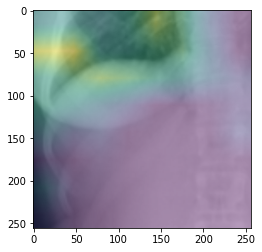

In [14]:
gradcam(model,testset[3][0].unsqueeze(0).cuda())